In [30]:
import numpy as np
import random
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import sqrtm
from skimage.transform import resize
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.layers import Activation, Dense, Input, Dropout, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Layer
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import metrics
from keras.applications.inception_v3 import preprocess_input, InceptionV3
import keras.backend as K


In [31]:
## Constants
OLD_IMAGE_DIMS = (218, 178, 3)
NEW_IMAGE_DIMS = (64, 64, 3)
BATCH_SIZE = 32
N = 10000
NUM_ATTRIBUTES = 40
NUM_BATCHES = 200
LATENT_DIM = 64
TOT_IMAGES = 202599
EPOCHS = 100

In [32]:
# Defining the paths to the dataset. Only use one of these

# Paths for Kaggle
PATH = '../input/celeba-dataset/'
IMAGES = "img_align_celeba/img_align_celeba/"
ATTRIBUTES = "../input/list-attr-celebatxt/list_attr_celeba.txt"

# Paths for running locally
#PATH = './'
#IMAGES = 'img_align_celeba/'
#ATTRIBUTES = 'list_attr_celeba.txt'

In [33]:
# Collecting the attributes from file
def get_attributes(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    attributes = []
    attr = []
    i = 0
    for line in lines:
        if i != 0 and i != 1:
            line = line.split()
            attributes.append(line)
        i += 1
    f.close()
    return attributes

# Collecting the names of all 40 possible attributes
def get_attribute_names(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    return lines[1].split()

# Function that makes a training set
def initialize_training_set(): 
    all_attributes = get_attributes(ATTRIBUTES)
    
    while True:
        chosen_info = random.sample(all_attributes, BATCH_SIZE)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        resized_images = []
    
        for ind in range(len(chosen_info)):
            image_path = PATH + IMAGES + chosen_images[ind]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        chosen_attributes = np.array(chosen_attributes, dtype=np.float32)

        yield [resized_images, chosen_attributes], None 
        
# Function that makes a test set
def initialize_test_set():
    all_attributes = get_attributes(ATTRIBUTES)
    info_in_batches = []
    attributes_in_batches = []
    images_in_batches = []
    test_set = []
    
    for i in range(NUM_BATCHES):
        chosen_info = random.sample(all_attributes, BATCH_SIZE)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        
        info_in_batches.append(chosen_info)
        attributes_in_batches.append(chosen_attributes)
        images_in_batches.append(chosen_images)
        
    for i in range(NUM_BATCHES):
        chosen_images = images_in_batches[i]
        attributes = attributes_in_batches[i]
        resized_images = []
        
        for j in range(BATCH_SIZE):
            image_path = PATH + IMAGES + chosen_images[j]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        attributes = np.array(chosen_attributes, dtype=np.float32)

        test_set.append([resized_images, attributes])
    return test_set

# Initializing a training set and a test set
training_set = initialize_training_set()
test_set = initialize_test_set()

In [34]:
# Creating the cVAE model

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

def VAE():
    # Encoding
    input_img = Input(shape = NEW_IMAGE_DIMS, name='input_img')
    labels = Input(shape = (NUM_ATTRIBUTES,), name='labels')

    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(input_img)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 512, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)

    shape_before_flattening = K.int_shape(x)[1:]

    x = Flatten()(x)

    z_mean = Dense(LATENT_DIM, name='z_mean')(x)
    z_log_sigma = Dense(LATENT_DIM, name='z_log_sigma')(x)
    z = Sampling()([z_mean, z_log_sigma])

    zy = Concatenate()([z, labels])

    inputs_embedding = Input(shape=(LATENT_DIM + NUM_ATTRIBUTES,))
    embedding = Dense(np.prod(shape_before_flattening))(inputs_embedding)
    embedding = Reshape(shape_before_flattening)(embedding)

    #Decoding
    x_ = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(embedding)
    x_ = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
    x_ = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
    x_ = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
    x_ = Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,  padding = 'same', activation = 'sigmoid')(x_)

    encoder = Model(inputs = [input_img, labels], outputs = zy, name="encoder")
    decoder = Model(inputs = inputs_embedding, outputs = x_, name="decoder")

    vae_out = decoder(encoder([input_img, labels]))

    rec_loss =  np.prod(NEW_IMAGE_DIMS) * binary_crossentropy(Flatten()(input_img), Flatten()(vae_out))
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    vae_loss = K.mean(rec_loss + kl_loss)

    vae = Model(inputs = [input_img, labels], outputs = vae_out, name="vae")

    vae.add_loss(vae_loss)

    optimizer = Adam(lr=0.0005, beta_1 = 0.5)
    vae.compile(optimizer)

    return vae, encoder, decoder

vae, encoder, decoder = VAE()

encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 32, 32, 32)   896         input_img[0][0]                  
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 16, 16, 64)   18496       conv2d_104[0][0]                 
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 8, 8, 128)    73856       conv2d_105[0][0]                 
____________________________________________________________________________________________

In [35]:
# Function to reconstruct given images
def reconstruct_images(test_set):
    print('Reconstructing images')
    images_for_fid = []
    predictions_for_fid = []
    
    index = 1
    
    for batch in test_set:
        print('Batch:', index)
        example_images = batch[0] * 255.0
        example_predictions = vae.predict(batch) * 255.0
        
        # Scaling images
        scaled_images = scale_images(example_images, (299, 299, 3))
        scaled_predictions = scale_images(example_predictions, (299, 299, 3))
        
        # Pre-processing images
        preprocessed_images = preprocess_input(scaled_images)
        preprocessed_predictions = preprocess_input(scaled_predictions)
        
        act1 = model.predict(preprocessed_images)
        act2 = model.predict(preprocessed_predictions)
        
        images_for_fid.append(act1)
        predictions_for_fid.append(act2)
                      
        index += 1

    return example_images, example_predictions, images_for_fid, predictions_for_fid

# Functions to generate new images given user-specified attributes
def generate_images(generated_attributes):
    print('')
    print('Generating images')
    
    predictions_for_fid = []
    
    images = np.random.normal(0,1,size = (NUM_BATCHES * BATCH_SIZE, LATENT_DIM)).astype(np.float32)
    
    #np.random.uniform(-1, 1, size = (NUM_BATCHES * BATCH_SIZE, LATENT_DIM)).astype(np.float32)
    
    for i in range(NUM_BATCHES):
        print('Batch:', i+1)
        batch = []
        
        for j in range(BATCH_SIZE):
            img_info = []
            img_info.append(np.concatenate((images[j].flatten(), generated_attributes)))
            batch.append(np.array(img_info).flatten())
            
        batch = np.array(batch)
        predictions = decoder.predict(batch) * 255.0
        
        # Scaling images
        scaled_predictions = scale_images(predictions, (299, 299, 3))
        
        # Pre-processing images
        preprocessed_predictions = preprocess_input(scaled_predictions)
        
        #Making activations
        act = model.predict(preprocessed_predictions)
        
        predictions_for_fid.append(act)

    return predictions, predictions_for_fid

In [36]:
# Calculate Frechet Inception Distance (https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/)

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [37]:
# Function to display images
def show_images(batch):
    used_indices = []
    nrow = 2
    ncol = 8
    fig = plt.figure(figsize=((ncol+1)*1.5, (nrow+1)*1.5)) 
    gs = mpl.gridspec.GridSpec(nrow, ncol,
             wspace=0.0, hspace=0.0, 
             top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
    for i in range(16):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(batch[i])
        plt.axis('off')
    plt.show()

## Training our model

In [38]:
# Training the model
vae.fit(training_set, steps_per_epoch = N//BATCH_SIZE, verbose = 1, epochs = EPOCHS)

Epoch 1/100
312/312 [==============================] - 126s 405ms/step - loss: 7363.3374
Epoch 2/100
312/312 [==============================] - 126s 405ms/step - loss: 6955.4878
Epoch 3/100
312/312 [==============================] - 151s 485ms/step - loss: 6858.5488
Epoch 4/100
312/312 [==============================] - 125s 401ms/step - loss: 6802.7959
Epoch 5/100
312/312 [==============================] - 124s 399ms/step - loss: 6772.9966
Epoch 6/100
312/312 [==============================] - 124s 398ms/step - loss: 6739.3989
Epoch 7/100
312/312 [==============================] - 124s 398ms/step - loss: 6710.6509
Epoch 8/100
312/312 [==============================] - 125s 400ms/step - loss: 6716.6880
Epoch 9/100
312/312 [==============================] - 148s 475ms/step - loss: 6693.1738
Epoch 10/100
312/312 [==============================] - 124s 399ms/step - loss: 6691.6841
Epoch 11/100
312/312 [==============================] - 124s 399ms/step - loss: 6667.9473
Epoch 12/100
312/31

312/312 [==============================] - 122s 392ms/step - loss: 6584.6353
Epoch 93/100
312/312 [==============================] - 122s 392ms/step - loss: 6596.9614
Epoch 94/100
312/312 [==============================] - 121s 389ms/step - loss: 6593.7114
Epoch 95/100
312/312 [==============================] - 121s 389ms/step - loss: 6596.2612
Epoch 96/100
312/312 [==============================] - 122s 391ms/step - loss: 6587.2539
Epoch 97/100
312/312 [==============================] - 121s 389ms/step - loss: 6609.1519
Epoch 98/100
312/312 [==============================] - 122s 392ms/step - loss: 6595.6572
Epoch 99/100
312/312 [==============================] - 121s 389ms/step - loss: 6583.8159
Epoch 100/100
312/312 [==============================] - 122s 391ms/step - loss: 6574.7734


In [39]:
# Save model weights
vae.save_weights('./vae.h5')
decoder.save_weights('./decoder.h5')
encoder.save_weights('./encoder.h5')

In [40]:
# Preparing the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

## Reconstructing faces

In [41]:
# Reconstructing images with VAE
rec_images, rec_predictions, images_for_fid, rec_predictions_for_fid = reconstruct_images(test_set) 

Reconstructing images
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 

Original images


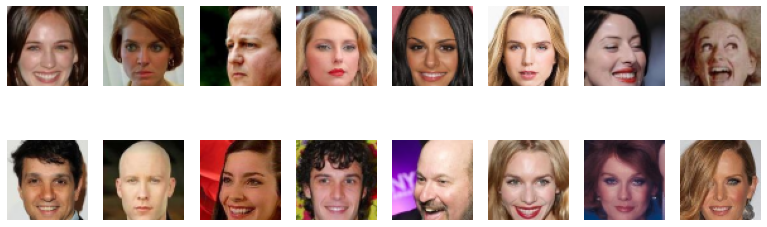



Reconstructed images


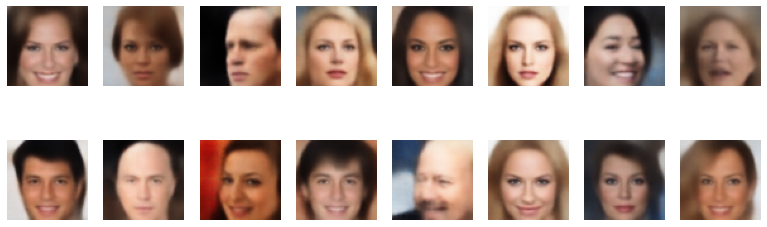

In [42]:
print('Original images')
show_images(rec_images/255.0)
print('\n')
print('Reconstructed images')
show_images(rec_predictions/255.0)

## Generating new faces

In [43]:
# Showing all possible attributes user can pick from and their index
attributes = get_attribute_names(ATTRIBUTES)

for i in range(len(attributes)):
    print(i, attributes[i])

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [44]:
# Picking user-specified attributes

# Initializing attributes
chosen_attributes = np.ones(NUM_ATTRIBUTES, dtype=np.float32) * -1

# Example 1
#chosen_attributes[4] = 1  # bald
#chosen_attributes[22] = 1 # mustache

# Example 2
#chosen_attributes[8] = 1   # black hair
#chosen_attributes[20] = 1  # male
#chosen_attributes[31] = 1  # smiling

# Example 3
chosen_attributes[13] = 1  # chubby
chosen_attributes[18] = 1 # heavy makeup
chosen_attributes[32] = 1  # straight hair

In [45]:
# Generating new images with VAE
gen_predictions, gen_predictions_for_fid = generate_images(chosen_attributes)


Generating images
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99


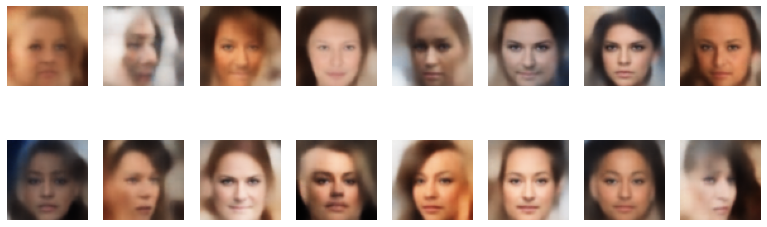

In [46]:
show_images(gen_predictions/255.0)

## Fréchet Inception Distance

In [47]:
fid_score = calculate_fid(np.array(images_for_fid).reshape((-1, 2048)), np.array(rec_predictions_for_fid).reshape((-1, 2048)))
print('FID for reconstructed images:', fid_score)

FID for reconstructed images: 71.16822975641603


In [48]:
fid_score = calculate_fid(np.array(images_for_fid).reshape((-1, 2048)), np.array(gen_predictions_for_fid).reshape((-1, 2048)))
print('FID for reconstructed images:', fid_score)

FID for reconstructed images: 149.42197150788866
